In [1]:
import sympy as sm

In [2]:
sm.init_printing()

# Define variables

In [3]:
m, M, Ic, k, b, l, g = sm.symbols('m, M, I_c, k, b, l, g', real=True, positive=True)

In [4]:
t = sm.symbols('t', real=True)

In [5]:
x = sm.Function('x')(t)
v = sm.Function('v')(t)
theta = sm.Function('theta')(t)
omega = sm.Function('omega')(t)

# Kinetic energy

In [6]:
vc_squared = (v - omega*l*sm.sin(theta))**2 + (omega*l*sm.cos(theta))**2
vc_squared

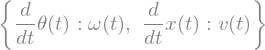

In [7]:
eq_repl = {theta.diff(t): omega, x.diff(t): v}
eq_repl

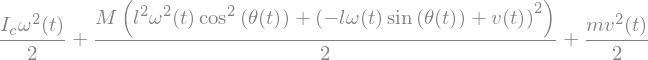

In [8]:
T = m*v**2/2 + M*vc_squared/2 + Ic*omega**2/2
T

# Potential energy

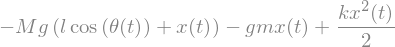

In [9]:
U = k*x**2/2 -m*g*x - M*g*(x + l*sm.cos(theta))
U

# Damping

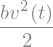

In [10]:
R = b*v**2/2
R

# Lagrange's Equation

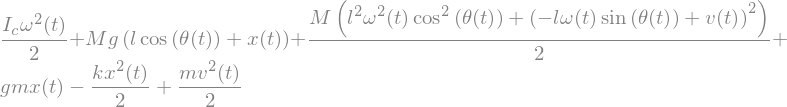

In [11]:
L = T - U
L

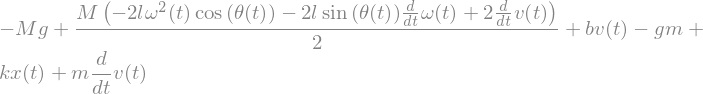

In [12]:
leq_v = L.diff(v).diff(t).subs(eq_repl) - L.diff(x) -(-R.diff(v))
leq_v

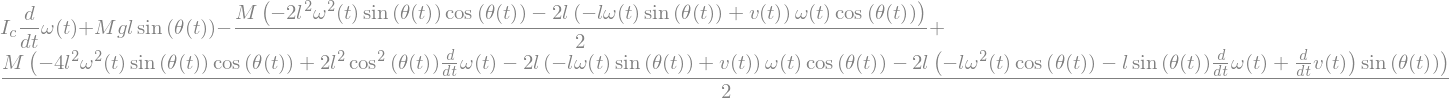

In [13]:
leq_omega = L.diff(omega).diff(t).subs(eq_repl) - L.diff(theta) -(-R.diff(omega))
leq_omega

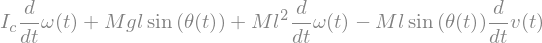

In [14]:
leq_omega = sm.simplify(leq_omega)
leq_omega

# Put EoM in explicit first order form

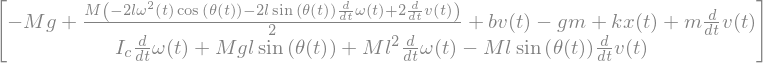

In [15]:
f = sm.Matrix([leq_v, leq_omega])
f

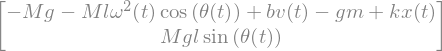

In [16]:
g = f.subs({omega.diff(t): 0, v.diff(t): 0})
g

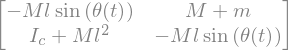

In [17]:
I = f.jacobian([omega.diff(t), v.diff(t)])
I

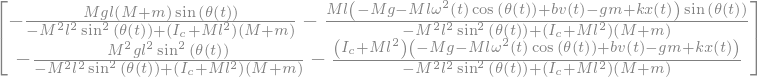

In [18]:
sdot = -I.inv()*g
sdot

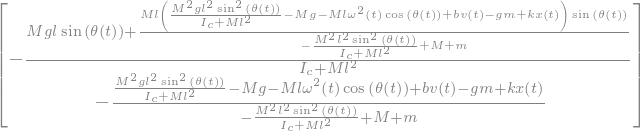

In [19]:
sdot = -I.LUsolve(g)
sdot

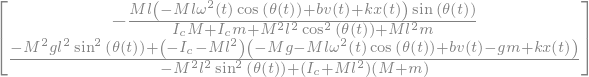

In [20]:
sm.simplify(sdot)

# Simulate the non-linear system

In [21]:
from resonance.nonlinear_systems import MultiDoFNonLinearSystem

In [22]:
sys = MultiDoFNonLinearSystem()

In [23]:
sys.constants['m'] = 1.0  # kg
sys.constants['k'] = 10.0  # N/m
sys.constants['b'] = 5.0  # Ns
sys.constants['l'] = 0.5  # m
sys.constants['M'] = 0.5  # kg
sys.constants['Ic'] = 0.5*0.5**2  # kg m**2
sys.constants['g'] = 9.81  # m/s**2

In [24]:
# order of entry matters!
sys.coordinates['theta'] = 1.0  # rad
sys.coordinates['x'] = 0.0  # m
sys.speeds['omega'] = 0.0 # rad/s
sys.speeds['v'] = 0.0 # m/s

In [25]:
sys.states

_StatesDict([('theta', 1.0), ('x', 0.0), ('omega', 0.0), ('v', 0.0)])

In [26]:
eval_mass = sm.lambdify((m, M), m+M)

In [27]:
eval_mass(1.0, 2.0)

In [28]:
g = sm.symbols('g', real=True, positive=True)

In [29]:
eval_sdot = sm.lambdify((theta, x, omega, v, m, k, b, l, M, Ic, g), [sdot[0], sdot[1]])

In [30]:
eval_sdot(1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0)

In [31]:
def eval_derivatives(theta, x, omega, v, m, k, b, l, M, Ic, g):
    omegadot, vdot = eval_sdot(theta, x, omega, v, m, k, b, l, M, Ic, g)
    thetadot = omega
    xdot = v
    return thetadot, xdot, omegadot, vdot

In [32]:
eval_derivatives(1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0)

In [33]:
sys.diff_eq_func = eval_derivatives

In [34]:
trajectories = sys.free_response(5.0)

In [35]:
%matplotlib widget

In [36]:
trajectories[['x', 'theta']].plot(subplots=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8dab65f4a8>,
      dtype=object)

# Find the equilibrium

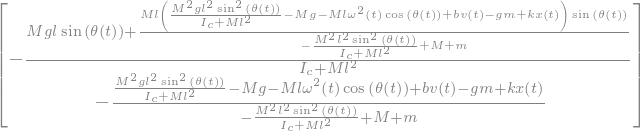

In [37]:
sdot

In [38]:
sdot_no_motion = sdot.subs({omega: 0, v: 0})

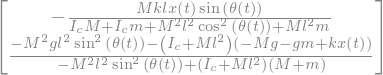

In [39]:
sm.simplify(sdot_no_motion)

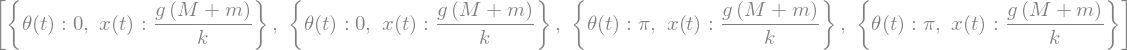

In [40]:
sm.solve(sdot_no_motion, theta, x)

# Linearize

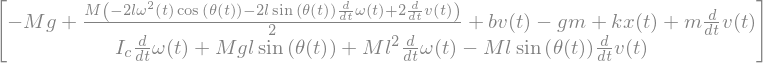

In [41]:
f

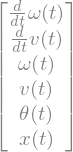

In [42]:
vbar = sm.Matrix([omega.diff(t), v.diff(t), omega, v, theta, x])
vbar

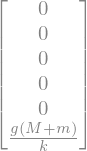

In [43]:
vbareq = sm.Matrix([0, 0, 0, 0, 0, g*(M + m)/k])
vbareq

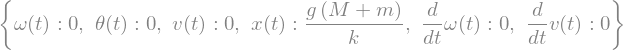

In [44]:
vbar_repl = {k: v for k, v in zip(vbar, vbareq)}  # dictionary comphrension
vbar_repl

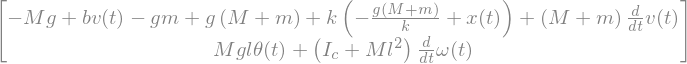

In [45]:
flin = f.subs(vbar_repl) + f.jacobian(vbar).subs(vbar_repl)*(vbar - vbareq)
flin

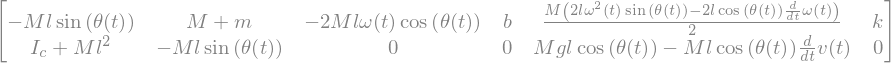

In [46]:
f.jacobian(vbar)

# Linear canonical form

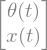

In [47]:
cbar = sm.Matrix([theta, x])
cbar

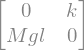

In [48]:
K = flin.jacobian(cbar)
K

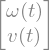

In [49]:
sbar = sm.Matrix([omega, v])
sbar

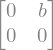

In [50]:
C = flin.jacobian(sbar)
C

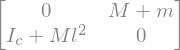

In [51]:
M_mat = flin.jacobian(sbar.diff(t))
M_mat

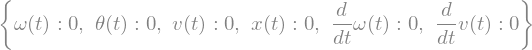

In [52]:
zero_repl = {k: v for k, v in zip(vbar, [0, 0, 0, 0, 0, 0])}
zero_repl


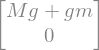

In [53]:
F = -flin.subs(zero_repl)
F

# Simulate the linear system

In [54]:
from resonance.linear_systems import MultiDoFLinearSystem

sys = MultiDoFLinearSystem()

sys.constants['m'] = 1.0  # kg
sys.constants['k'] = 10.0  # N/m
sys.constants['b'] = 5.0  # Ns
sys.constants['l'] = 0.5  # m
sys.constants['M'] = 0.5  # kg
sys.constants['Ic'] = 0.5*0.5**2  # kg m**2
sys.constants['g'] = 9.81  # m/s**2
sys.coordinates['theta'] = 1.0  # rad
sys.coordinates['x'] = 0.0  # m
sys.speeds['omega'] = 0.0 # rad/s
sys.speeds['v'] = 0.0 # m/s

In [55]:
import numpy as np

In [56]:
np.array([[1, 2], [3, 4]])

array([[1, 2],
       [3, 4]])

In [57]:
def calc_coeff_mats(m, k, b, l, M, Ic, g):
    M_mat = np.array([[0, M+m],
                  [Ic+m*l**2, 0]])
    C = np.array([[0, b],
                  [0, 0]])
    K = np.array([[0, k],
                  [M*g*l, 0]])
    return M_mat, C, K

In [58]:
sys.canonical_coeffs_func = calc_coeff_mats

In [59]:
sys.canonical_coefficients()

(array([[0.   , 1.5  ],
        [0.375, 0.   ]]), array([[0., 5.],
        [0., 0.]]), array([[ 0.    , 10.    ],
        [ 2.4525,  0.    ]]))

In [60]:
sys.coordinates['x'] = 0.1

In [61]:
traj = sys.free_response(5.0)

In [62]:
traj[['x', 'theta']].plot(subplots=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8dab554f60>,
      dtype=object)